<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/master/suman_test_CIFAR_10_EVA4_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.utils.data import Dataloader as dataloader
import torch.optim as optim

import torchvision
from torchvision import datasets,transforms

from torchsummary import summary

from tqdm import tqdm

import  matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace

import numpy as np


In [2]:
# 1. Download datasets and apply transforms
train_transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataset = datasets.CIFAR10(root='./root',train=True,download=True,transform=train_transformation)

testDataset = datasets.CIFAR10(root='./root',train=False,download=True,transform=test_transformation)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = trainDataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Calculation of mean and var and std
print(type(trainDataset.data))
print(trainDataset.data.shape)
print(np.mean(trainDataset.data))
print(np.var(trainDataset.data))
print(np.std(trainDataset.data))

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
120.70756512369792
4115.232236836622
64.1500758911213


In [4]:
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainDataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testDataset, **dataloader_args)

CUDA Available? True


128
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
tensor([0, 5, 4, 4, 9, 3, 9, 9, 3, 3, 0, 7, 0, 5, 5, 4, 1, 1, 6, 1, 6, 5, 8, 3,
        1, 6, 4, 2, 4, 2, 3, 7, 1, 3, 3, 8, 7, 0, 0, 0, 9, 0, 6, 7, 8, 4, 2, 0,
        3, 5, 2, 9, 5, 3, 4, 5, 5, 6, 7, 6, 8, 4, 0, 9, 0, 6, 7, 6, 9, 5, 2, 5,
        6, 9, 4, 9, 6, 1, 2, 6, 6, 2, 9, 5, 1, 1, 3, 5, 6, 5, 9, 3, 1, 1, 4, 8,
        7, 9, 5, 9, 6, 8, 7, 7, 5, 0, 5, 4, 7, 3, 2, 6, 7, 8, 2, 0, 3, 5, 7, 2,
        0, 2, 2, 0, 3, 3, 8, 1])
  airplane        dog       deer       deer


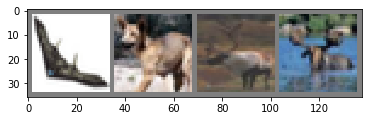

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(len(images))
print(trainDataset.class_to_idx)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drpout = nn.Dropout(0.16)
        self.conv_layer1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            drpout,
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            drpout,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            # Conv Layer block 2
            # Dilated conv
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2,dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            drpout,
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            drpout,
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout2d(p=0.05)
        )
        self.conv_layer3 = nn.Sequential(
            # Conv Layer block 3
            # Depthwise sep Conv
            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,groups=128),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            drpout,
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            drpout,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer4 = nn.Sequential(
            # Conv Layer block 4
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #drpout,
            #nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1, padding=0),
            #nn.ReLU()
            nn.AvgPool2d(kernel_size=4)
          )

    def forward(self, x):
        # conv layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        #return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
#set_trace()
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

In [0]:
net = Net()
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [10]:
epochs= 6
model.train()
for epoch in range(epochs):  # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
    #for images, labels in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

0
1
2
3
4
5
Finished Training


GroundTruth:      dog    truck     frog automobile


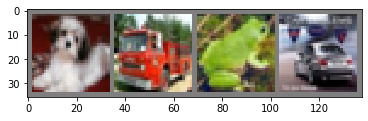

In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()


# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join('%8s' % classes[labels[j]] for j in range(4)))

In [12]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship truck  ship airplane


In [13]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print(i)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

0
Accuracy of airplane : 90 %
1
Accuracy of automobile : 88 %
2
Accuracy of  bird : 84 %
3
Accuracy of   cat : 85 %
4
Accuracy of  deer : 93 %
5
Accuracy of   dog : 71 %
6
Accuracy of  frog : 86 %
7
Accuracy of horse : 84 %
8
Accuracy of  ship : 87 %
9
Accuracy of truck : 88 %
